## Initial import

In [17]:
## Always keep!!! Initial import
%reset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
import matplotlib.dates as mdates

#plt.rcParams["figure.figsize"] = [7.50, 3.50]
#plt.rcParams["figure.autolayout"] = True

#Extract CSV filling data. Each column is a different skip
skip_filling_df = pd.read_csv('../../data/raw_data/Skip-fullness-blantyre-raw.csv')

#Setting the index of the dataframe to the date and convert to datetime
skip_filling_df.set_index('date', inplace=True)
skip_filling_df.index = pd.to_datetime(skip_filling_df.index)


#Remove '.' and dates with all NaN values, convert all to float
skip_filling_df = skip_filling_df.replace('.', np.nan)
skip_filling_df = skip_filling_df.astype(float)
skip_filling_df.dropna(axis=1, how='all', inplace=True)


#List of the skips
skip_dfCol = skip_filling_df.columns
#Number of columns, or skips
numSkips = len(skip_dfCol)

skip_filling_df = skip_filling_df.copy()
skip_filling_df[skip_filling_df < 8] *= 4 / 7
skip_filling_df[skip_filling_df == 8] = 5

binNum = 3 # selected bin for analysis

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


## Graphing functions

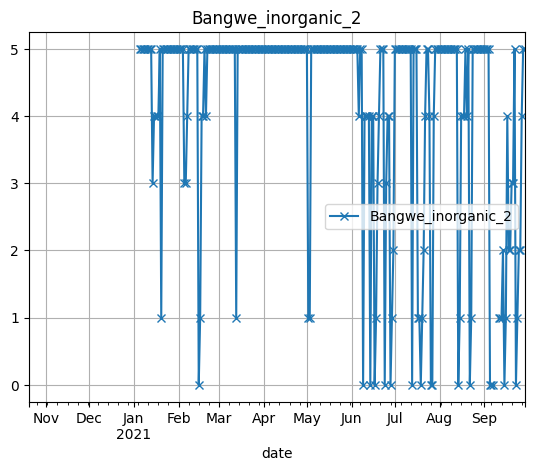

In [44]:
type_graph = 2

totY = 4
totX = 4
if type_graph == 1:
    #print(skip_filling_df[skip_dfCol[9]])
    #print(skip_filling_df.columns)
    figure, axis = plt.subplots(totX, totY)
    for i in range(totX):
        for j in range(totY):
            if j+4*i >= numSkips:
                break
            skip_filling_df.plot(ax=axis[i, j], use_index=True, y=skip_dfCol[j + 4 * i], grid=True, marker='x')
            # doesn't show missing data i.e. long straight values are as such in raw data
            axis[i, j].set_title(skip_filling_df.columns[j + 4 * i])
            axis[i, j].set_yticks([0,1,2,3,4,5])
            axis[i, j].get_legend().remove()
    plt.show()
elif type_graph == 2:
    figure, axis = plt.subplots()
    skip_filling_df.plot(ax=axis,use_index=True, y=skip_dfCol[binNum], grid=True, marker='x')
    plt.title(skip_filling_df.columns[binNum])
    #plt.show()


## Ramp rates algo

In [45]:
##########################################
## Ramp detection and profile extraction
##
## Goals: 
##     - Remove spikes
##    - Detect end of top of ramps, then beginning
##     - Remove derating increases
##     - Find start of ramps 
##########################################

skip_filling_interest = skip_filling_df[skip_dfCol[binNum]].copy().dropna() #Drops NaN from the df
diff_pos = skip_filling_interest.diff() #difference val(n) - val(n-1) #Get the difference in fullness between subsequent datapoints
diff_neg = skip_filling_interest.diff(periods=-1) #difference val(n) - val(n+1) #Get the difference in the negative direction
td_1 = pd.Timedelta(1, "d") #Define 1 days as a timedelta (pandas tool)


## Removing 1 day back to original spikes (positive and negative) Forward pass
# diff_index_pos = skip_filling_interest.index.to_series().diff() #Index difference between  points (important for NaN)
# diff_index_neg = skip_filling_interest.index.to_series().diff(periods=-1)
skip_filling_interest_no_spike = skip_filling_interest.drop(skip_filling_interest[diff_pos - diff_neg == 0][diff_pos != 0].index)#[diff_index_pos == td_1][diff_index_neg == -td_1])

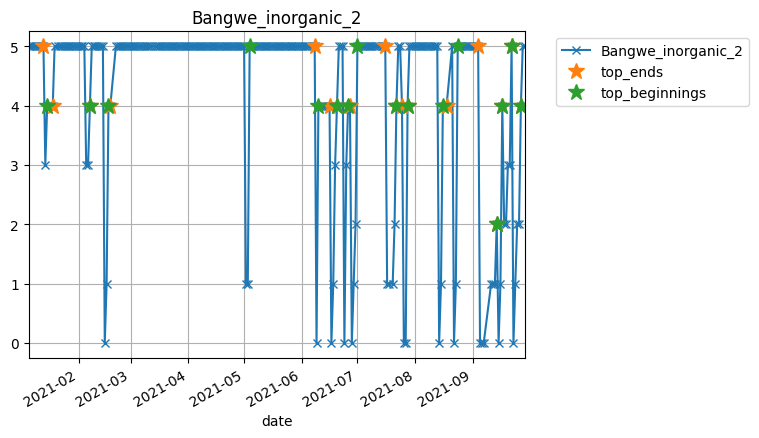

In [69]:
## Top ends - forward pass
indices_no_spike = skip_filling_interest_no_spike.index #Get indices for the current working df series

i = 0 #Counting
imax = 0 #Loop protection variable

top_ends = pd.DataFrame(columns=['top_ends']) #df with the ending of top of ramps
while i <= len(indices_no_spike) and imax < 600:
    imax = imax+1
    for j in range(len(indices_no_spike)-i-1):
        if skip_filling_interest_no_spike.loc[indices_no_spike[i+j+1]] >= skip_filling_interest_no_spike.loc[indices_no_spike[i+j]]:
            if i+j+1 == len(indices_no_spike)-1:
                top_ends.loc[indices_no_spike[i+j+1]] = skip_filling_interest_no_spike.loc[indices_no_spike[i+j+1]]
                i = i+j+1
                break
            elif skip_filling_interest_no_spike.loc[indices_no_spike[i+j]] == 4 and skip_filling_interest_no_spike.loc[indices_no_spike[i+j+1]] == 5:
                top_ends.loc[indices_no_spike[i+j]] = skip_filling_interest_no_spike.loc[indices_no_spike[i+j]]
                imax2 = 0
                while  i+j+1 <= len(indices_no_spike)-1 and skip_filling_interest_no_spike.loc[indices_no_spike[i+j+1]] == 5 and imax2 < 600:
                    imax2 = imax2+1
                    if i+j+1 <= len(indices_no_spike)-1:
                        j = j+1
                    else:
                        break
                i = i + j + 1
                break
            else:
                pass
        else:
            top_ends.loc[indices_no_spike[i+j]] = skip_filling_interest_no_spike.loc[indices_no_spike[i+j]]
            i = i+j+1
            break

## Move top ends to top beginnings, eliminates plateau from analysis. Backward pass
top_beginnings = pd.DataFrame(columns=['top_beginnings'])
i = len(top_ends)-1
imax = 0
while i >= 0 and imax < 600:
    imax = imax+1
    for j in range(indices_no_spike.get_loc(top_ends.index[i])):
        if skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_ends.index[i])-j-1]] == skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_ends.index[i])-j]]:
            pass
        elif skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_ends.index[i])-j-1]] < skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_ends.index[i])-j]]:
            top_beginnings.loc[indices_no_spike[indices_no_spike.get_loc(top_ends.index[i])-j]] = skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_ends.index[i])-j]]
            i = i - 1
            #add to list 
            break
        else:
            i = i - 1
            break
            
figure, axis = plt.subplots()
skip_filling_interest_no_spike.plot(ax=axis,use_index=True, y=skip_dfCol[binNum], grid=True, marker='x')
plt.title(skip_filling_df.columns[binNum])
top_ends.plot(use_index=True, grid=True, marker='*', ax = axis, linestyle='none', markersize=12)
top_beginnings.plot(use_index=True, grid=True, marker='*', ax = axis, linestyle='none', markersize=12)
plt.xlim(skip_filling_interest.index.min(),skip_filling_interest.index.max())
axis.legend(bbox_to_anchor=(1.05, 1))
plt.show()

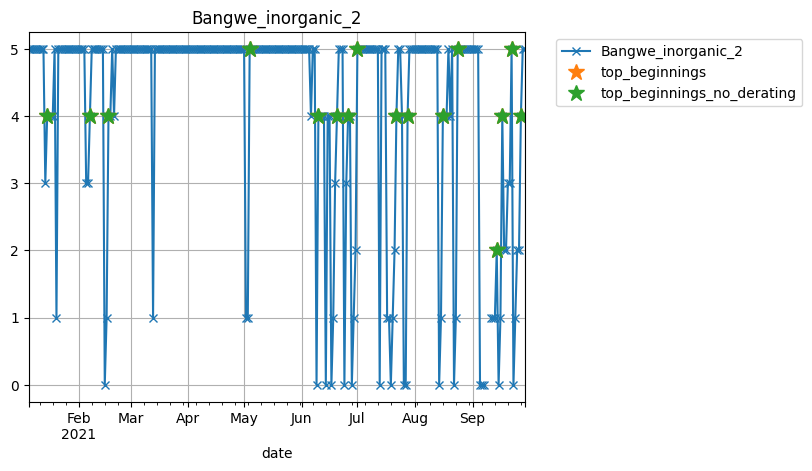

In [68]:
## Remove derating (backward pass)
top_beginnings_no_derating = pd.DataFrame(columns=['top_beginnings_no_derating'])
i = len(top_beginnings[top_beginnings==5])-1
imax = 0
while i >= 0 and imax < 600:
    imax = imax+1
    for j in range(indices_no_spike.get_loc(top_beginnings[top_beginnings==5].index[i])):
        if skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings[top_beginnings==5].index[i])-j-1]] == 4:
            pass
        elif skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings[top_beginnings==5].index[i])-j-1]] < 4:
            top_beginnings_no_derating.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings[top_beginnings==5].index[i])]] = skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings[top_beginnings==5].index[i])]]
            i = i - 1
            #add to list 
            break
        else:
            i = i - 1
            break
            
figure, axis = plt.subplots()
skip_filling_df.plot(ax=axis,use_index=True, y=skip_dfCol[binNum], grid=True, marker='x')
plt.title(skip_filling_df.columns[binNum])
top_beginnings.plot(use_index=True, grid=True, marker='*', ax = axis, linestyle='none', markersize=12)
top_beginnings_no_derating.plot(use_index=True, grid=True, marker='*', ax = axis, linestyle='none', markersize=12)
plt.xlim(skip_filling_interest.index.min(),skip_filling_interest.index.max())
axis.legend(bbox_to_anchor=(1.05, 1))
plt.show()

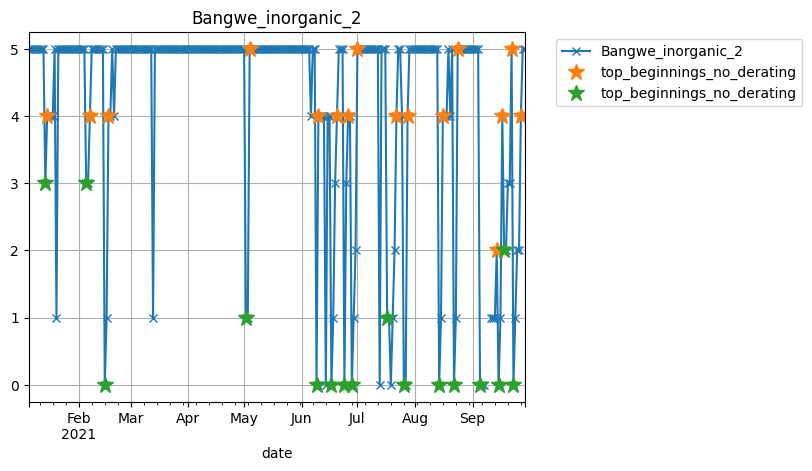

In [67]:
## Find bottoms (backward pass) walk back for as long as it decreases or equals previous
bottom_beginnings = pd.DataFrame(columns=['top_beginnings_no_derating'])
i = len(top_beginnings_no_derating)-1
imax = 0
while i >= 0 and imax < 600:
    imax = imax+1
    for j in range(indices_no_spike.get_loc(top_beginnings_no_derating.index[i])):
        if indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j-1 == 0:
            bottom_beginnings.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j]] = skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j]]
            i = i - 1
            break
        elif skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j-1]] <= skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j]]:
            pass
        else:
            bottom_beginnings.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j]] = skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j]]
            i = i - 1
            #add to list 
            break
            
figure, axis = plt.subplots()
skip_filling_df.plot(ax=axis,use_index=True, y=skip_dfCol[binNum], grid=True, marker='x')
plt.title(skip_filling_df.columns[binNum])
top_beginnings_no_derating.plot(use_index=True, grid=True, marker='*', ax = axis, linestyle='none', markersize=12)
bottom_beginnings.plot(use_index=True, grid=True, marker='*', ax = axis, linestyle='none', markersize=12)
plt.xlim(skip_filling_interest.index.min(),skip_filling_interest.index.max())
axis.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [70]:
#Join data

# Ordering both lists by date
top_beginnings_no_derating.sort_index(inplace = True)
bottom_beginnings.sort_index(inplace = True)

# Joining together
tops = top_beginnings_no_derating.reset_index()
tops.columns = ['index_top', 'value_top']
bottoms = bottom_beginnings.reset_index()
bottoms.columns = ['index_bottom', 'value_bottom']
POI_df = pd.concat([bottoms,tops], axis = 1)


list_mc = []
for i in POI_df.values.tolist():
    tuple1 = [mdates.date2num(i[0].to_pydatetime()), i[1]]
    tuple2 = [mdates.date2num(i[2].to_pydatetime()), i[3]]
    list_mc.append([tuple1,tuple2])
#print(list_mc)
ramps = []
POI_df['ramp rate'] = ((POI_df.value_top-POI_df.value_bottom).astype(float)/((POI_df.index_top-POI_df.index_bottom).dt.days).astype(float))/4

1.0
4.0
3.0


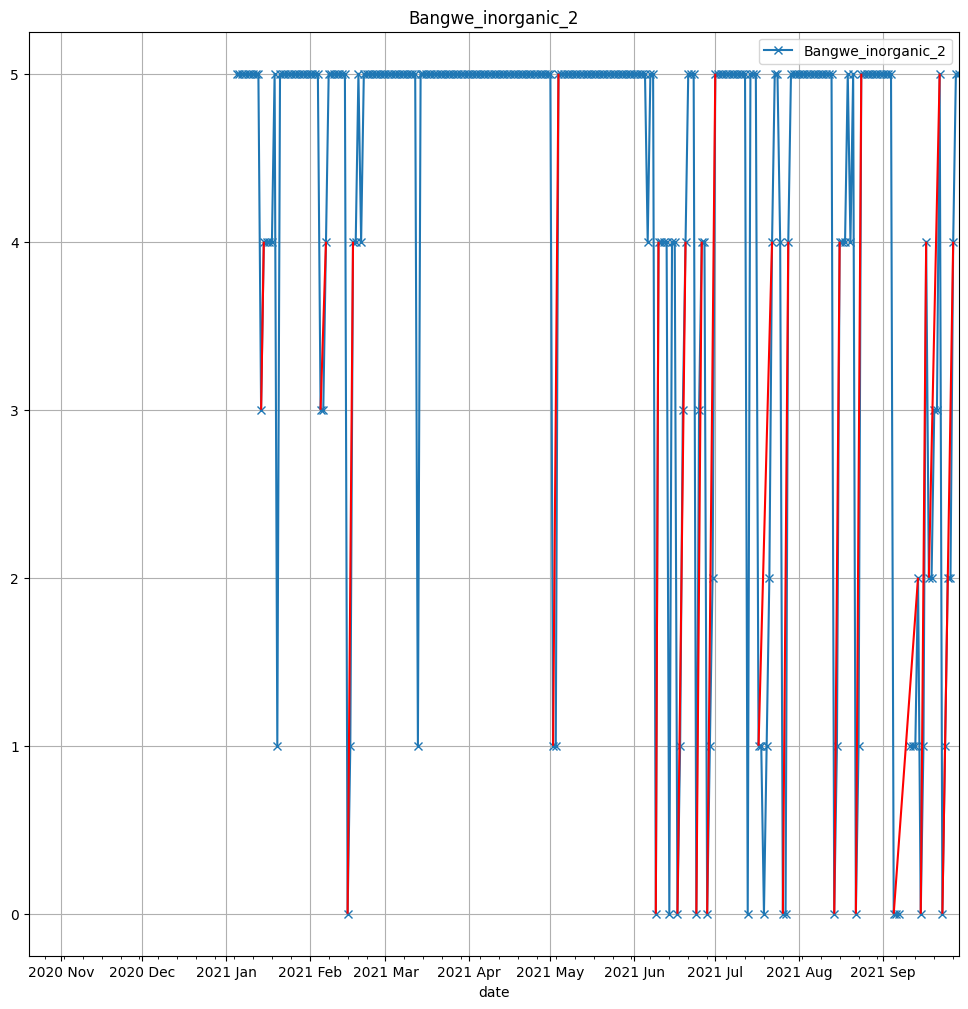

In [14]:
type = 2

totY = 4
totX = 4
if type == 1:
    print(skip_filling_df[skip_dfCol[binNum]])
    #print(skip_filling_df.columns)
    figure, axis = plt.subplots(totX, totY)
    for i in range(totX):
        for j in range(totY):
            if j+4*i >= numSkips:
                break
            skip_filling_df.plot(ax=axis[i, j], use_index=True, y=skip_dfCol[j + 4 * i], grid=True, marker='x')
            # doesn't show missing data i.e. long straight values are as such in raw data
            axis[i, j].set_title(skip_filling_df.columns[j + 4 * i])
            axis[i, j].set_yticks([0,1,2,3,4,5])
            axis[i, j].get_legend().remove()
    plt.show()
elif type == 2:
    fig, ax = plt.subplots(figsize=(12,12))
    skip_filling_df.plot(ax = ax,use_index=True, y=skip_dfCol[binNum], grid=True, marker='x')
    #skip_filling_interest_no_spike.plot(ax = ax,use_index=True, grid=True, marker='x')
    #top_ends.plot(use_index=True, grid=True, marker='*', ax = ax, linestyle='none', markersize=12)
    #top_beginnings.plot(use_index=True, grid=True, marker='*', ax = ax, linestyle='none', markersize=12)
    #top_beginnings_no_derating.plot(use_index=True, grid=True, marker='*', ax = ax, linestyle='none', markersize=12)
    #bottom_beginnings.plot(use_index=True, grid=True, marker='*', ax = ax, linestyle='none', markersize=12)
    lc = mc.LineCollection(list_mc, color='red')
    ax.add_collection(lc)
    plt.title(skip_filling_df.columns[binNum])
    ax.autoscale_view()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    monthFmt = mdates.DateFormatter("%Y %b")
    ax.xaxis.set_major_formatter(monthFmt)
    plt.show()